In [1]:
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
from math import gcd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import umap
from Modules import file_navigation
from Modules import rnaseqTools
from Modules import plot_ax_violin
from Modules import plot_ax_gene_violin
from Modules import rnaseqTools
from matplotlib.backends.backend_pdf import PdfPages

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

color_dict = file_navigation.get_color_dict()

In [2]:
def get_lin_data():
    params = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df_labels = pd.read_csv(fname, na_values='Other', **params)
    df_labels = df_labels.loc[df_labels.Age>20,:]
    df_labels.sort_values('Age', inplace=True)
    
    fname = 'Datasets/Lab_Pvalb-tpm.tsv'
    df_tpm = pd.read_csv(fname, **params)
    df_tpm = df_tpm.loc[:,df_labels.index].copy()
    
    arrays = [df_labels.index, df_labels['Morph-PV-types']]
    names = ('Cell', 'CellType')
    df_tpm.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df_tpm

def get_olm_data():
    params = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_OLM-labels.tsv'
    df_labels = pd.read_csv(fname, **params)
    
    fname = 'Datasets/Lab_OLM-tpm.tsv'
    df_tpm = pd.read_csv(fname, **params)
    df_tpm = df_tpm.loc[:,df_labels.CellType == 'SST-OLM']
    
    arrays = [df_tpm.columns, ['SST-OLM'] * df_tpm.shape[1]]
    names = ('Cell', 'CellType')
    df_tpm.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df_tpm

def get_harris_data():
    params = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/GSE99888-labels.tsv'
    df_labels = pd.read_csv(fname, **params)
    
    fname = 'Datasets/GSE99888-tpm.tsv'
    df_tpm = pd.read_csv(fname, **params)
    
    df_labels = df_labels.loc[df_labels.CellType.str.startswith('Pvalb'),:]
    df_tpm = df_tpm.loc[:,df_labels.index].copy()
    
    arrays = [df_tpm.columns, df_labels.CellType]
    names = ('Cell', 'CellType')
    df_tpm.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df_tpm

def get_cams():
    fname = '/home/soma/Documents/Newest/analysisfiles/CAMmouse.txt'
    with open(fname) as f:
        cams = [line.split()[0] for line in f] + ['Pcdhgc5', 'Nectin2']
    
    return cams

def read_data():
    df_lin = get_lin_data()
    df_olm = get_olm_data()
    df_harris = get_harris_data()
    
    cams = get_cams()
    kept = df_lin.index.isin(cams)
    
    df_lin = df_lin.loc[kept,:]
    df_olm = df_olm.loc[kept,:]
    df_harris = df_harris.loc[kept,:]
    
    df = np.log2(1+pd.concat((df_lin, df_olm, df_harris), axis=1).T)
    
    return df

def get_differential_gene_set(target, fdr=5):
    directory = 'Differential/edgeR/%s' % (target.split('-PV-types')[0])
    fnames = glob.glob('%s/*.txt' % directory)
    
    genes = []
    
    for fname in fnames:
        df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
        df = df.loc[np.abs(df.logFC)>1]
        df_sig = df.loc[df.FDR<fdr/100]
        
        if df_sig.shape[0] > 0:
            genes.append(df_sig.index.tolist())
        
    return genes

def get_differential_genes(targets, fdr=5):
    gene_sets = [get_differential_gene_set(target, fdr=fdr) for target in targets]
    gene_set = [{gene for genes in gene_set for gene in genes} for gene_set in gene_sets]
    genes = sorted({gene for genes in gene_set for gene in genes})
    
    return genes

def get_top_genes(directory, n=5):
    directory = 'Differential/edgeR/%s' % directory
    fnames = glob.glob('%s/*.txt' % directory)
    
    gene_datas = []
    for fname in fnames:
        df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
        df = df.loc[np.abs(df.logFC)>1]
        gene_datas.append(df.FDR)
    
    gene_data = pd.concat(gene_datas, axis=1, sort=False)
    
    gene_signifs = gene_data.min(axis=1)
    
    return gene_signifs.nsmallest(n=n).index.tolist()

def get_classifications(df):
    index = df.index.get_level_values('Cell')
    columns = ['CellType', 'Csaba', 'Soma']
    df_labels = pd.DataFrame('', index=index, columns=columns)
    
    df_labels.CellType = df.index.get_level_values('CellType')
    add_labels_csaba(df, df_labels)
    add_labels_soma(df, df_labels)
    
    return df_labels

def get_lcm(*args):
    """
    get lowest common multiple of a series of numbers, and what they need to be multiplied by
    to get that large
    """
    lcm = 1
    for number in args:
        lcm = (lcm * number) // gcd(lcm, number)
    
    multiples = [lcm // number for number in args]
    
    return lcm, multiples
    

def get_sorted_order(df_tpm):
    """
    hierarchically sort a dataframe
    despite different cell types having different number of cells, we want to weigh them evenly
    """
    
    # get lowest common multiple, and how much cells need to be multiplied by
    labels = df_tpm.index.get_level_values('CellType')
    counts = labels.value_counts()
    lcm, multiple = get_lcm(*counts)
    
    # construct artifically inflated dataset
    datalist = df_tpm.values.T
    datalists = []
    for label, mult in zip(counts.index, multiple):
        data = datalist[:,labels==label]
        datalists.append(np.tile(data, mult))
    datalist = np.hstack(datalists)
    
    # do hierarchical sorting
    Z = linkage(datalist, method='average', metric='euclidean')
    D = dendrogram(Z, no_plot=True)
    index = D['leaves']
    
    df_tpm = df_tpm.iloc[:,index]
    
    return df_tpm

def do_heatmap(fig, axrange, df_tpm,
               tick_size=6,
               gene_set=None,
               label_genes=False,
               orientation='horizontal',
               row_labels=[],
               order=['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC', 'SST-OLM']):
    # get data of interest
    if len(order) == 0:
        order = sorted(set(df_tpm.index.get_level_values('CellType')))
    df_tpm = df_tpm.loc[df_tpm.index.get_level_values('CellType').isin(order),:]
    high = df_tpm.values.max()*1.01
    
    # sort genes
    if gene_set == None:
        df_sorted = get_sorted_order(df_tpm)
        gene_set = [df_sorted.columns.tolist()]
    
    if len(row_labels) < len(gene_set):
        row_labels += [''] * (len(gene_set) - len(row_labels))
    
    df_tpm = df_tpm.T
    
    # calculate target sizes
    Left, Bottom, Width, Height = axrange
    dW = .0022
    dH = .0017
    W = (Width - dW*(len(order)-1)) / df_tpm.shape[1]
    H = (Height - dH*(len(gene_set)-1)) / sum([len(genes) for genes in gene_set])
    
    top = Bottom + Height
    
    # plot data
    for row, (genes, row_label) in enumerate(zip(gene_set, row_labels)):
        height = H * len(genes)
        left = Left
        for col, celltype in enumerate(order):
        # get parameters for each column
            df_celltype = df_tpm.loc[genes,df_tpm.columns.get_level_values('CellType')==celltype]
            width = W * df_celltype.shape[1]
        
            # generate axes
            ax = fig.add_axes([left, top - height, width, height])
            if row == 0:
                ax.set_title(celltype, fontsize=5)
            if col != 0 and False:
                ax.spines['left'].set_visible(False)
            if col == 0 and label_genes:
                ax.set_yticks(np.arange(len(genes))+.5)
                ax.set_yticklabels(genes, fontsize=5)
                ax.tick_params(size=0, labelsize=5)
            else:
                ax.set_yticks([])
            if col == len(order)-1:
                kwargs = {'ha':'left', 'va':'center', 'rotation':90, 'fontsize':5}
                fig.text(left+width+.005, top-height/2, row_label, **kwargs)
            ax.set_xticks([])

            # do plot
            pcol = ax.pcolor(df_celltype.values, vmin=0, vmax=high, cmap=mpl.cm.Reds)
            pcol.set_edgecolor('face')
            ax.axis([0,df_celltype.shape[1], 0, df_celltype.shape[0]])

            left += width + dW
        
        top = top - (height + dH)
    
    if orientation == 'horizontal':
        cax = fig.add_axes([Left, Bottom-.010, Width/2, .005])
        fig.text(Left+Width/2+.005, Bottom-.005, 'log2 (Norm. gene exp.)', ha='left', va='top', fontsize=6)
    else:
        cax = fig.add_axes([Left+Width+.01, Bottom, .01, Height])
    plt.colorbar(pcol, cax=cax, orientation=orientation)
    cax.tick_params(size=1, labelsize=5, pad=1)
    
    return

In [3]:
%%time

# read in data

df_all = read_data()
df_pvalb = df_all.loc[df_all.index.get_level_values('Cell').str.startswith('O')]
df_cam = df_all.loc[:,(df_pvalb.values>1).sum(axis=0)>2]

CPU times: user 27.9 s, sys: 857 ms, total: 28.8 s
Wall time: 28.8 s


In [4]:
def plot_cam(fig, df, directories, category_set, violin_args={}):
    gene_set = [get_top_genes(directory, n=8) for directory in directories]
    
    args = (fig, df, category_set, gene_set)
    plot_ax_gene_violin.create_gene_violins(*args, **violin_args)
    
    return

def order_similarity_matrix(df_sim):
    indices = df_sim.columns
    if 'Continent 2' in indices:
        order = ['Continent 2', 'Continent 3' ,'SST-OLM']
    elif 'Fcer1g.Bcl2a1b' in indices:
        order = ['Map6d1.Sil1', 'Map6d1.Stat5b', 'Fcer1g.Bcl2a1b', 'Fcer1g.Hhatl', 'SST-OLM']
    elif 'BIC' in indices:
        order = ['AAC', 'BIC', 'BC', 'SST-OLM']
    elif 'hBIC' in indices:
        order = ['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC', 'SST-OLM']
    else:
        order = ['Vertical', 'Horizontal', 'SST-OLM']
    
    df_sim = df_sim.loc[order, order]
    return df_sim

def get_similarity_matrix(df, labels):
    datalist = df.values
    corr = rnaseqTools.corr2(datalist, datalist)
    df_sim = pd.DataFrame(corr, index=labels, columns=labels)
    
    inds = np.arange(df_sim.shape[0])
    df_sim.values[inds,inds] = np.NaN
    
    df_sim = df_sim.groupby(df_sim.index).mean().groupby(df_sim.columns,axis=1).mean()
    df_sim = order_similarity_matrix(df_sim)
    
    return df_sim

def plot_similarity_matrices(fig, df_cam, top):
    fig.text(.37, top+.02, 'CAM-based similarity', ha='center', va='bottom', fontsize=8)
    
    params = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df_labels = pd.read_csv(fname, na_values='Other', **params)
    index = df_labels.index.isin(df_cam.index.get_level_values('Cell'))
    columns = ['Morph-PV-types', 'MorphMarker-PV-types', 'MorphDirectional-PV-types',]
    titles = ['Five morphological\ntypes', 'Axo-morphological\ntypes', 'Dendro-morphological\ntypes']
    df_labels = df_labels.loc[index, columns].copy()
    olms = df_cam.xs('SST-OLM', level='CellType', axis=0).index
    for olm in olms:
        df_labels.loc[olm,:] = 'SST-OLM'
    
    df_cam = df_cam.loc[df_cam.index.get_level_values('Cell').isin(df_labels.index),:].copy()
    df_cam.index = df_cam.index.get_level_values('Cell')
    
    for num, (category, title) in enumerate(zip(df_labels.columns, titles)):
        df_sim = get_similarity_matrix(df_cam, df_labels[category])
        if num > 0:
            df_sim = df_sim.iloc[:-1,:-1]
        df_sim = df_sim.iloc[::-1]
        
        row = num // 2
        col = num % 2
        
        width = .10
        height = width / 11 * 8.5
        
        if row == 0:
            bottom = top - height
        else:
            bottom = .39
        if col == 0:
            left = .26
        else:
            left = .38
        
        ax = fig.add_axes([left, bottom, width, height])
        ax.set_title(title, y=.96, fontsize=6)
        pcol = ax.pcolor(df_sim.values, vmin=0.3, vmax=0.6, cmap=mpl.cm.Reds)
        ax.axis([0,df_sim.shape[1],0,df_sim.shape[0]])
        pcol.set_edgecolor('#000000')
        ticks = np.arange(df_sim.shape[0])+.5
        tick_labels = df_sim.columns
        ax.set_xticks(ticks), ax.set_xticklabels(tick_labels, rotation=35, ha='right')
        tick_labels = df_sim.index
        ax.set_yticks(ticks), ax.set_yticklabels(tick_labels)
        if col == 1:
            ax.yaxis.tick_right()
        ax.tick_params(size=1, pad=1, labelsize=6)
        
    cax = fig.add_axes([.38, .39, .01, height])
    plt.colorbar(pcol, cax=cax, orientation='vertical')
    cax.tick_params(size=1, labelsize=5, pad=1)
    
    text = "Pearson's\ncorrelation\ncoefficient"
    fig.text(.42, .39+height, text, fontsize=6, ha='left', va='top')
    
    return

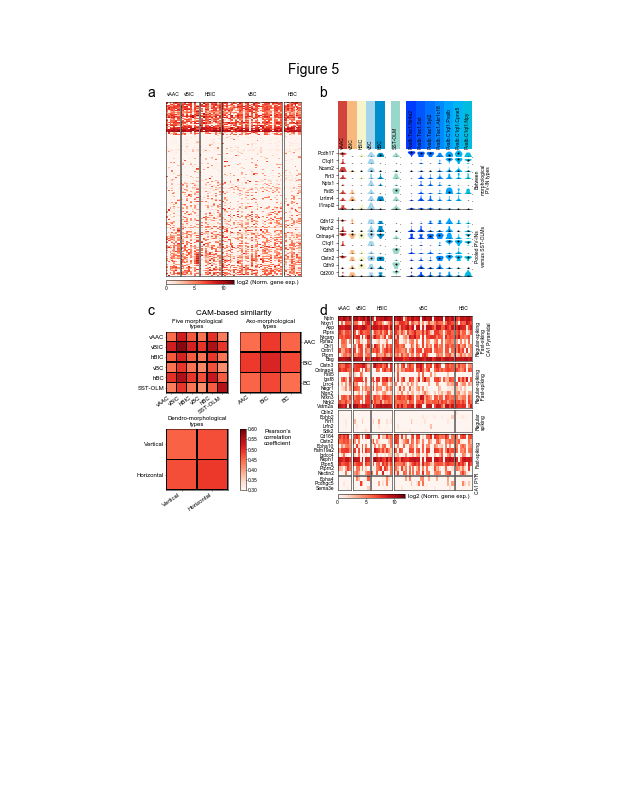

CPU times: user 15.8 s, sys: 2.4 s, total: 18.2 s
Wall time: 13.4 s


In [5]:
%%time

fig = plt.figure(figsize=(8.5,11))
axbg = fig.add_axes([0,0,1,1], frame_on=False)
axbg.set_xticks([]), axbg.set_yticks([])
fig.suptitle('Figure 5', fontsize=14, y=.93)
kwargs = {'ha':'left', 'va':'top', 'fontsize':14}
fig.text(.23, .900, 'a', **kwargs)
fig.text(.51, .900, 'b', **kwargs)
fig.text(.23, .625, 'c', **kwargs)
fig.text(.51, .625, 'd', **kwargs)
        
axrange = [.26, .66, .22, .22]
do_heatmap(fig, axrange, df_cam, tick_size=6, order=['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC'])

category_set = [['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC'],
              ['SST-OLM'],
              ['Pvalb.Tac1.Nr4a2',
               'Pvalb.Tac1.Sst',
               'Pvalb.Tac1.Syt2',
               'Pvalb.Tac1.Akr1c18',
               'Pvalb.C1ql1.Pvalb',
               'Pvalb.C1ql1.Cpne5',
               'Pvalb.C1ql1.Npy']
             ]
directories = ['Morph_CAM', 'Lab_CAM']
labels = ['Between\nmorphological\nPV-IN types', 'Pooled PV-INs\nversus SST-OLMs']
violin_args = {'left':.54,
               'right':.76,
               'top':.82,
               'bottom':.66,
               'axbg':axbg,
               'rec_height':.06,
               'namesize':5,
               'labelsize':5,
               'group_labels':labels
              }
plot_cam(fig, df_all, directories, category_set, violin_args=violin_args)

gene_set = [['Bsg', 'Ptprn', 'Cntn1', 'Chl1', 'Ppfia2', 'Nrcam', 'Ptprs', 'App', 'Nrxn1', 'Nptn'],
            ['Vstm2a', 'Ntrk2', 'Nrxn3', 'Nlgn2', 'Negr1', 'Lrrc4', 'Igsf8', 'Fstl5', 'Cntnap4', 'Clstn3'],
            ['Sdk2', 'Lrfn2', 'Flrt1', 'Ephb2', 'Cbln2'],
            ['Nectin2', 'Ptprn2', 'Ptpn5', 'Nxph1', 'Igdcc4', 'Fam19a2', 'Epha10', 'Clstn2', 'Cd164'],
            ['Sema3e', 'Pcdhgc5', 'Epha4']
           ]
row_labels = ['Regular-spiking\n  Fast-siking\nCA1 Pyramidal',
              'Regular-spiking\n  Fast-spiking', 'Regular\nspiking', 'Fast-spiking', 'CA1 PYR']

axrange = [.54, .39, .22, .22]
kwargs = {'tick_size':6,
          'order':['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC'],
          'gene_set':gene_set,
          'label_genes':True,
          'orientation':'horizontal',
          'row_labels':row_labels
         }
do_heatmap(fig, axrange, df_all, **kwargs)

plot_similarity_matrices(fig, df_cam, .59)

fig.savefig('Figures/Figure 5.pdf')
plt.show()
plt.close()